Tutorial on how to visualize and also analyze the waveforms:
https://github.com/multichannelsystems/McsPyDataTools/blob/master/McsPyDataNotebooks/McsPy-Tutorial_DataAnalysis.ipynb

In [3]:
!pip list

Package            Version
------------------ -----------
asttokens          3.0.0
colorama           0.4.6
comm               0.2.3
debugpy            1.8.17
decorator          5.2.1
exceptiongroup     1.3.0
executing          2.2.1
importlib_metadata 8.7.0
ipykernel          7.0.0
ipython            8.37.0
jedi               0.19.2
jupyter_client     8.6.3
jupyter_core       5.8.1
matplotlib-inline  0.1.7
nest_asyncio       1.6.0
packaging          25.0
parso              0.8.5
pickleshare        0.7.5
pip                25.2
platformdirs       4.5.0
prompt_toolkit     3.0.52
psutil             7.1.0
pure_eval          0.2.3
Pygments           2.19.2
python-dateutil    2.9.0.post0
pywin32            311
pyzmq              27.1.0
setuptools         80.9.0
six                1.17.0
stack_data         0.6.3
tornado            6.5.2
traitlets          5.14.3
typing_extensions  4.15.0
wcwidth            0.2.14
wheel              0.45.1
zipp               3.23.0


In [5]:
!pip install -r requirements.txt


  Using cached spikeinterface-0.103.0-py3-none-any.whl.metadata (11 kB)
  Using cached quantities-0.16.2-py3-none-any.whl.metadata (8.4 kB)
  Using cached McsPyDataTools-0.4.3.tar.gz (2.1 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached probeinterface-0.3.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached asciitree-0.3.3.tar.gz (4.0 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached fasteners-0.20-py3-none-any.whl.metadata (4.8 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached flexcache-0.3-py3-none-any.whl.metadata (7.0 kB)
  Using cached flexparser-0.4-py3-none-any.whl.metadata (18 kB)
Using cached spikeinterface-0.103.0-py3-none-any.whl (1.1 MB)
   ---------------------------------------- 0.0/828.6 kB ? eta -:--:--
   ---------------------------------------- 828.6/828.6 kB 35.4 MB/s  0:00:00
   ------------------

  DEPRECATION: Building 'McsPyDataTools' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'McsPyDataTools'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  DEPRECATION: Building 'asciitree' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'asciitree'. Discussion can be found at https://github.com/pypa/pip/issues/6334


Imports

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

import os
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# MCS PyData tools
import McsPy
import McsPy.McsData
from McsPy import ureg, Q_

# VISUALIZATION TOOLS
import matplotlib.pyplot as plt
%matplotlib inline

# SUPRESS WARNINGS
import warnings
warnings.filterwarnings('ignore')

# autoreload modules
%load_ext autoreload
%autoreload 2

# import bombcell module
import bombcell as bc

✅ ipywidgets available - interactive GUI ready


In [3]:
import sys
from pathlib import Path
from pprint import pprint 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# See bombcell default params
## Get default parameters - we will see later in the notebook how to assess and fine-tune these
param = bc.get_default_parameters(None, 
                                  raw_file=None,
                                  meta_file=None,
                                  kilosort_version=2)

print("Bombcell parameters:")
pprint(param)

Bombcell parameters:
{'computeDistanceMetrics': False,
 'computeDrift': False,
 'computeSpatialDecay': True,
 'computeTimeChunks': False,
 'decompress_data': False,
 'deltaTimeChunk': 360,
 'detrendForUnitMatch': False,
 'detrendWaveform': True,
 'driftBinSize': 60,
 'duplicateSpikeWindow_s': 3.4e-05,
 'ephysKilosortPath': 'None',
 'ephys_meta_file': None,
 'ephys_sample_rate': 30000,
 'extractRaw': True,
 'gain_to_uV': None,
 'hillOrLlobetMethod': True,
 'isoDmin': 20,
 'lratioMax': 0.3,
 'maxDrift': 100,
 'maxMainPeakToTroughRatio_nonSomatic': 0.8,
 'maxNPeaks': 2,
 'maxNTroughs': 1,
 'maxPeak1ToPeak2Ratio_nonSomatic': 3,
 'maxPercSpikesMissing': 20,
 'maxRPVviolations': 0.1,
 'maxScndPeakToTroughRatio_noise': 0.8,
 'maxSpatialDecaySlopeExp': 0.1,
 'maxWvBaselineFraction': 0.3,
 'maxWvDuration': 1150,
 'minAmplitude': 40,
 'minNumSpikes': 300,
 'minPresenceRatio': 0.7,
 'minSNR': 5,
 'minSpatialDecaySlope': -0.008,
 'minSpatialDecaySlopeExp': 0.01,
 'minThreshDetectPeaksTroughs': 0.2

Functions 

In [ ]:
def  plot_analog_stream_channel(analog_stream, channel_idx, from_in_s=0, to_in_s=None, show=True):
    """
    Plots data from a single AnalogStream channel
    
    :param analog_stream: A AnalogStream object
    :param channel_idx: A scalar channel index (0 <= channel_idx < # channels in the AnalogStream)
    :param from_in_s: The start timestamp of the plot (0 <= from_in_s < to_in_s). Default: 0
    :param to_in_s: The end timestamp of the plot (from_in_s < to_in_s <= duration). Default: None (= recording duration)
    :param show: If True (default), the plot is directly created. For further plotting, use show=False
    """
    # extract basic information
    ids = [c.channel_id for c in analog_stream.channel_infos.values()]
    channel_id = ids[channel_idx]
    channel_info = analog_stream.channel_infos[channel_id]
    sampling_frequency = channel_info.sampling_frequency.magnitude
   
    # get start and end index
    from_idx = max(0, int(from_in_s * sampling_frequency))
    if to_in_s is None:
        to_idx = analog_stream.channel_data.shape[1]
    else:
        to_idx = min(analog_stream.channel_data.shape[1], int(to_in_s * sampling_frequency))
        
    # get the timestamps for each sample
    time = analog_stream.get_channel_sample_timestamps(channel_id, from_idx, to_idx)

    # scale time to seconds:
    scale_factor_for_second = Q_(1,time[1]).to(ureg.s).magnitude
    time_in_sec = time[0] * scale_factor_for_second
    
    # get the signal
    signal = analog_stream.get_channel_in_range(channel_id, from_idx, to_idx)

    # scale signal to µV:
    scale_factor_for_uV = Q_(1,signal[1]).to(ureg.uV).magnitude
    signal_in_uV = signal[0] * scale_factor_for_uV

    # construct the plot
    _ = plt.figure(figsize=(20,6))
    _ = plt.plot(time_in_sec, signal_in_uV)
    _ = plt.xlabel('Time (%s)' % ureg.s)
    _ = plt.ylabel('Voltage (%s)' % ureg.uV)
    _ = plt.title('Channel %s' % channel_info.info['Label'])
    if show:
        plt.show()

In [6]:
def extract_waveforms(signal, fs, spikes_idx, pre, post):
    """
    Extract spike waveforms as signal cutouts around each spike index as a spikes x samples numpy array
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param spikes_idx: The sample index of all spikes as a 1-dim numpy array
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    """
    cutouts = []
    pre_idx = int(pre * fs)
    post_idx = int(post * fs)
    for index in spikes_idx:
        if index-pre_idx >= 0 and index+post_idx <= signal.shape[0]:
            cutout = signal[(index-pre_idx):(index+post_idx)]
            cutouts.append(cutout)
    return np.stack(cutouts)

In [7]:
def detect_threshold_crossings(signal, fs, threshold, dead_time):
    """
    Detect threshold crossings in a signal with dead time and return them as an array
    
    The signal transitions from a sample above the threshold to a sample below the threshold for a detection and
    the last detection has to be more than dead_time apart from the current one.
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold: The threshold for the signal
    :param dead_time: The dead time in seconds. 
    """
    dead_time_idx = dead_time * fs
    threshold_crossings = np.diff((signal <= threshold).astype(int) > 0).nonzero()[0]
    distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    while not np.all(distance_sufficient):
        # repeatedly remove all threshold crossings that violate the dead_time
        threshold_crossings = threshold_crossings[distance_sufficient]
        distance_sufficient = np.insert(np.diff(threshold_crossings) >= dead_time_idx, 0, True)
    return threshold_crossings

def get_next_minimum(signal, index, max_samples_to_search):
    """
    Returns the index of the next minimum in the signal after an index
    
    :param signal: The signal as a 1-dimensional numpy array
    :param index: The scalar index 
    :param max_samples_to_search: The number of samples to search for a minimum after the index
    """
    search_end_idx = min(index + max_samples_to_search, signal.shape[0])
    min_idx = np.argmin(signal[index:search_end_idx])
    return index + min_idx

def align_to_minimum(signal, fs, threshold_crossings, search_range):
    """
    Returns the index of the next negative spike peak for all threshold crossings
    
    :param signal: The signal as a 1-dimensional numpy array
    :param fs: The sampling frequency in Hz
    :param threshold_crossings: The array of indices where the signal crossed the detection threshold
    :param search_range: The maximum duration in seconds to search for the minimum after each crossing
    """
    search_end = int(search_range*fs)
    aligned_spikes = [get_next_minimum(signal, t, search_end) for t in threshold_crossings]
    return np.array(aligned_spikes)

In [73]:
def plot_waveforms(cutouts, fs, pre, post, n=100, color='k', show=True):
    """
    Plot an overlay of spike cutouts
    
    :param cutouts: A spikes x samples array of cutouts
    :param fs: The sampling frequency in Hz
    :param pre: The duration of the cutout before the spike in seconds
    :param post: The duration of the cutout after the spike in seconds
    :param n: The number of cutouts to plot, or None to plot all. Default: 100
    :param color: The line color as a pyplot line/marker style. Default: 'k'=black
    :param show: Set this to False to disable showing the plot. Default: True
    """
    if n is None:
        n = cutouts.shape[0]
    n = min(n, cutouts.shape[0])
    time_in_us = np.arange(-pre*1000, post*1000, 1e3/fs)
    if show:
        _ = plt.figure(figsize=(12,6))
    
    for i in range(n):
        _ = plt.plot(time_in_us, cutouts[i,]*1e6, color, linewidth=1, alpha=0.3)
        _ = plt.xlabel('Time (%s)' % ureg.ms)
        _ = plt.ylabel('Voltage (%s)' % ureg.uV)
        _ = plt.title('Cutouts')
    
    if show:
        plt.show()

Code to visualize and analyze HDF files

In [120]:
# NOTE: for now this only takes HDF files as input but it would
# be nice if it could get the raw files too
FILE_PATH = "C:/Users/MEA-User/Documents/Multi Channel DataManager/2025-09-08T14-02-20AH-3Delectrode-BrainOrganoid-Brainphys-5min_B-00023.h5"
file = file = McsPy.McsData.RawData(FILE_PATH)
electrode_stream = file.recordings[0].analog_streams[0]

Recording_0 <HDF5 group "/Data/Recording_0" (1 members)>
Stream_0 <HDF5 group "/Data/Recording_0/AnalogStream/Stream_0" (3 members)>
ChannelData <HDF5 dataset "ChannelData": shape (60, 11106000), type "<i4">
ChannelDataTimeStamps <HDF5 dataset "ChannelDataTimeStamps": shape (1, 3), type "<i8">
InfoChannel <HDF5 dataset "InfoChannel": shape (60,), type "|V108">


In [231]:
# Check the labels for each index of the stream
for i in range(0,60):
    temp = electrode_stream.channel_infos[i]
    print(f"index: {i}, channel name: {temp.info['Label']}")

index: 0, channel name: B-00023 47
index: 1, channel name: B-00023 48
index: 2, channel name: B-00023 46
index: 3, channel name: B-00023 45
index: 4, channel name: B-00023 38
index: 5, channel name: B-00023 37
index: 6, channel name: B-00023 28
index: 7, channel name: B-00023 36
index: 8, channel name: B-00023 27
index: 9, channel name: B-00023 17
index: 10, channel name: B-00023 26
index: 11, channel name: B-00023 16
index: 12, channel name: B-00023 35
index: 13, channel name: B-00023 25
index: 14, channel name: B-00023 Ref
index: 15, channel name: B-00023 14
index: 16, channel name: B-00023 24
index: 17, channel name: B-00023 34
index: 18, channel name: B-00023 13
index: 19, channel name: B-00023 23
index: 20, channel name: B-00023 12
index: 21, channel name: B-00023 22
index: 22, channel name: B-00023 33
index: 23, channel name: B-00023 21
index: 24, channel name: B-00023 32
index: 25, channel name: B-00023 31
index: 26, channel name: B-00023 44
index: 27, channel name: B-00023 43
i

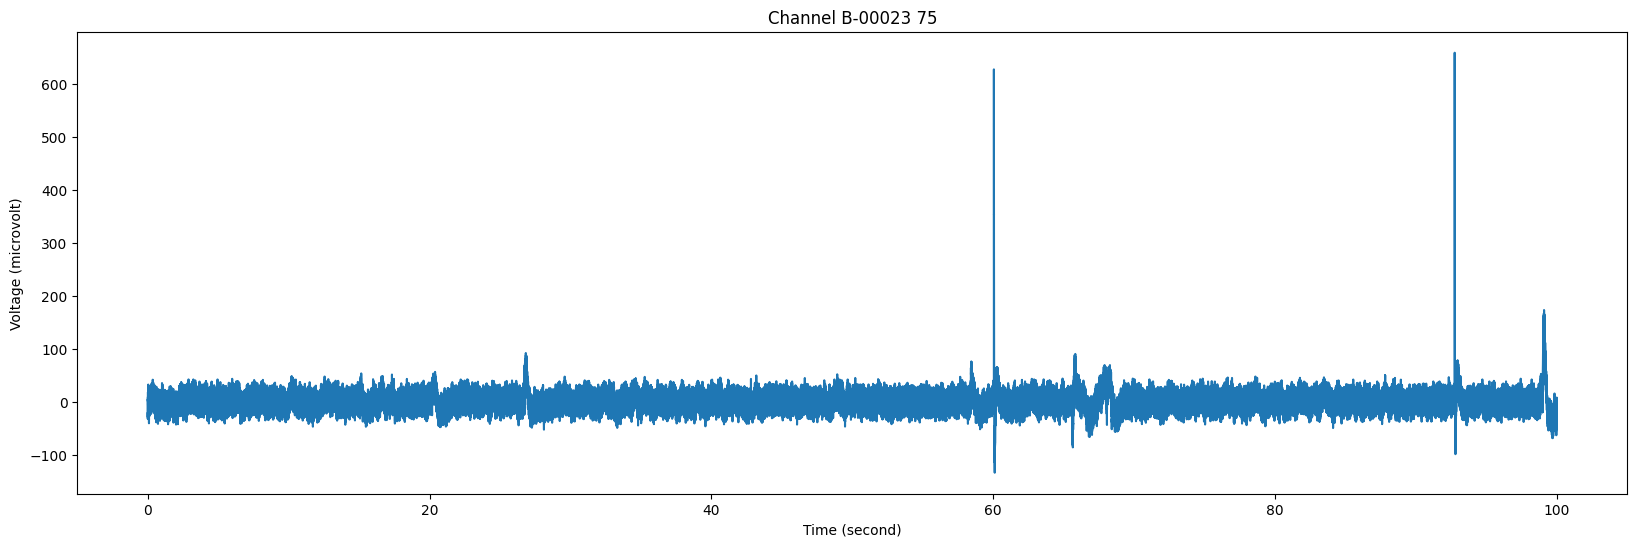

In [256]:
# Check the analog stream of the electrode in channel 0
plot_analog_stream_channel(electrode_stream, channel_idx = 46, from_in_s=0, to_in_s=100)

In [258]:
# Check the bandwidth of the recording to see if
# there have been any filters applied o
channel_id = 46
info = electrode_stream.channel_infos[channel_id].info
print("Bandwidth: %s - %s Hz" % (info['HighPassFilterCutOffFrequency'], info['LowPassFilterCutOffFrequency']))

signal = electrode_stream.get_channel_in_range(channel_id, 0, electrode_stream.channel_data.shape[1])[0]

Bandwidth: -1 - -1 Hz


In [259]:
# Determine suitable threshold for spike detection
noise_std = np.std(signal)
noise_mad = np.median(np.absolute(signal)) / 0.6745
print('Noise Estimate by Standard Deviation: {0:g} V'.format(noise_std))
print('Noise Estimate by MAD Estimator     : {0:g} V'.format(noise_mad))

Noise Estimate by Standard Deviation: 2.78048e-05 V
Noise Estimate by MAD Estimator     : 1.61759e-05 V


In [260]:
spike_threshold = -4 * noise_mad # roughly -30 µV

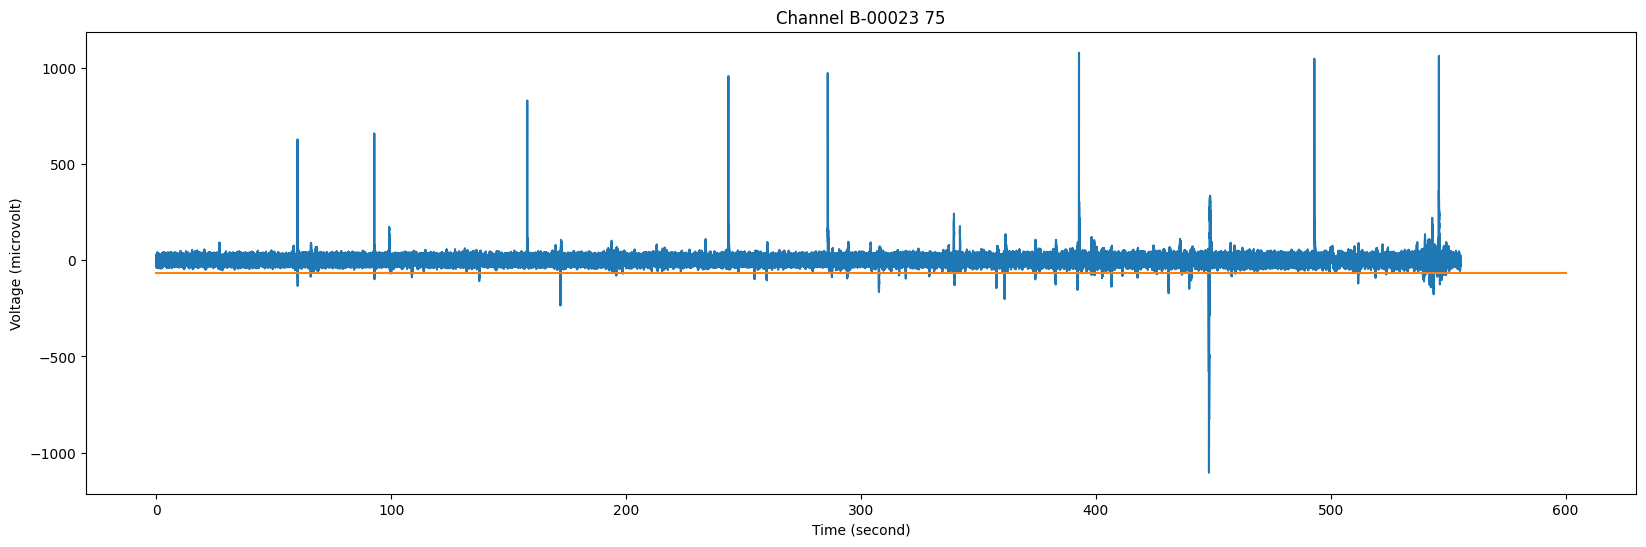

In [263]:
# Plot the data with the spike threshold
plot_analog_stream_channel(electrode_stream, 46, from_in_s=0, to_in_s=1000, show=False)

plt.plot([0, 600], [spike_threshold*1e6, spike_threshold*1e6]) # converts the threshold to µV for plotting
plt.show()

In [303]:
fs = int(electrode_stream.channel_infos[channel_id].sampling_frequency.magnitude)
crossings = detect_threshold_crossings(signal, fs, spike_threshold, 0.003) # dead time of 3 ms
spks = align_to_minimum(signal, fs, crossings, 0.002) # search range 2 ms

In [311]:
timestamps = spks / fs
range_in_s = (300, 360)
spikes_in_range = timestamps[(timestamps >= range_in_s[0]) & (timestamps <= range_in_s[1])]


In [312]:
spikes_in_range

array([307.60475, 307.7161 , 307.732  , 307.74395, 316.1878 , 316.20745,
       316.2283 , 316.23375, 319.03005, 319.03895, 319.043  , 319.0484 ,
       319.05325, 319.05865, 319.0671 , 319.0904 , 319.11045, 328.9797 ,
       328.9952 , 328.99835, 329.01455, 329.0354 , 329.0556 , 329.0743 ,
       329.095  , 329.10075, 329.11485, 339.6968 , 339.7008 , 339.7091 ,
       339.74905, 339.87615, 339.8865 , 339.8907 , 339.8995 , 339.9163 ,
       339.9247 , 339.93715, 357.5997 , 357.70335, 357.7116 , 357.7213 ,
       357.73325])

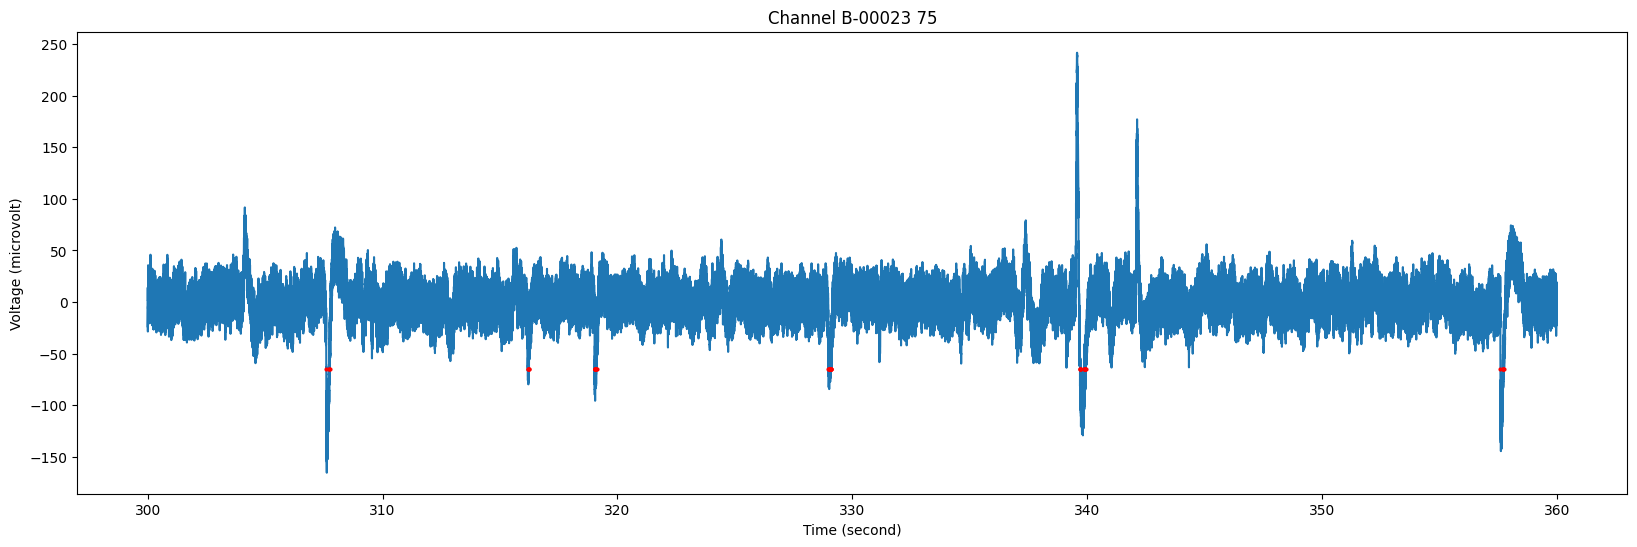

In [313]:

plot_analog_stream_channel(electrode_stream, channel_idx = 46, from_in_s=300, to_in_s=360, show=False)
plt.plot(spikes_in_range, [spike_threshold*1e6]*spikes_in_range.shape[0], 'ro', ms=2)
plt.show()

In [315]:
pre = 0.001 # 1 ms
post= 0.002 # 2 ms
cutouts = extract_waveforms(signal, fs, spks, pre, post)
print("Cutout array shape: " + str(cutouts.shape)) # number of spikes x number of samples

Cutout array shape: (373, 60)


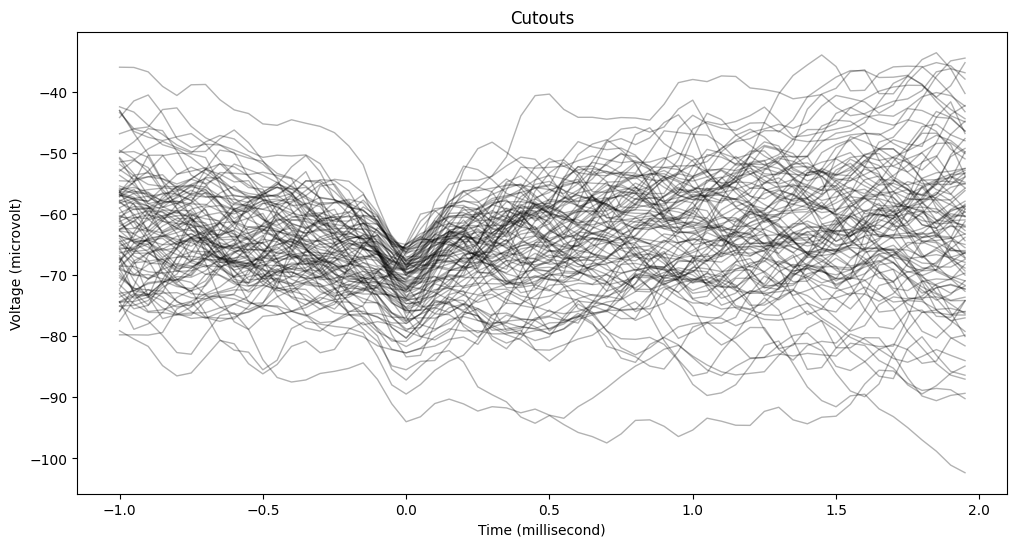

In [316]:
plot_waveforms(cutouts, fs, pre, post, n=100)


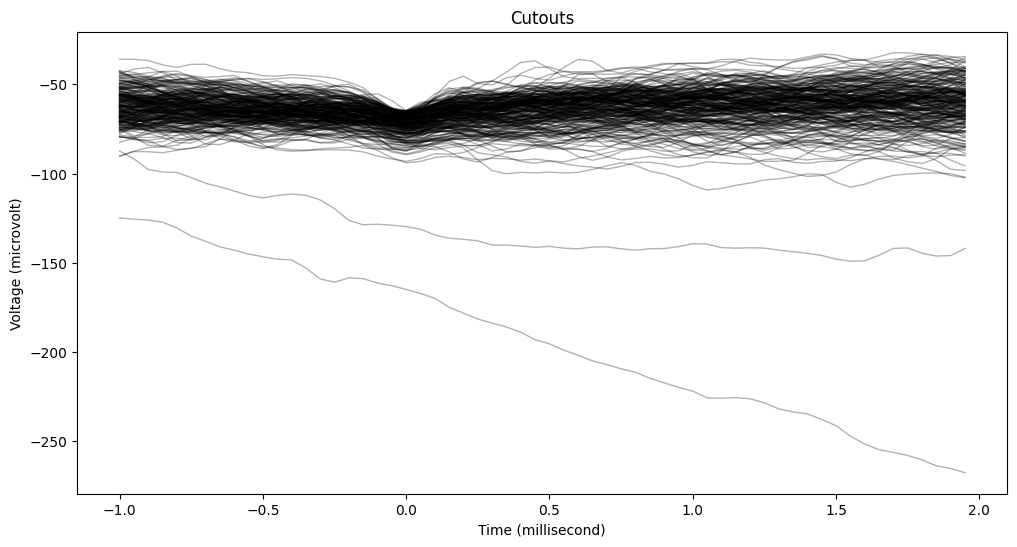

In [280]:
plot_waveforms(cutouts, fs, pre, post, n=250)


Analysis with PCA

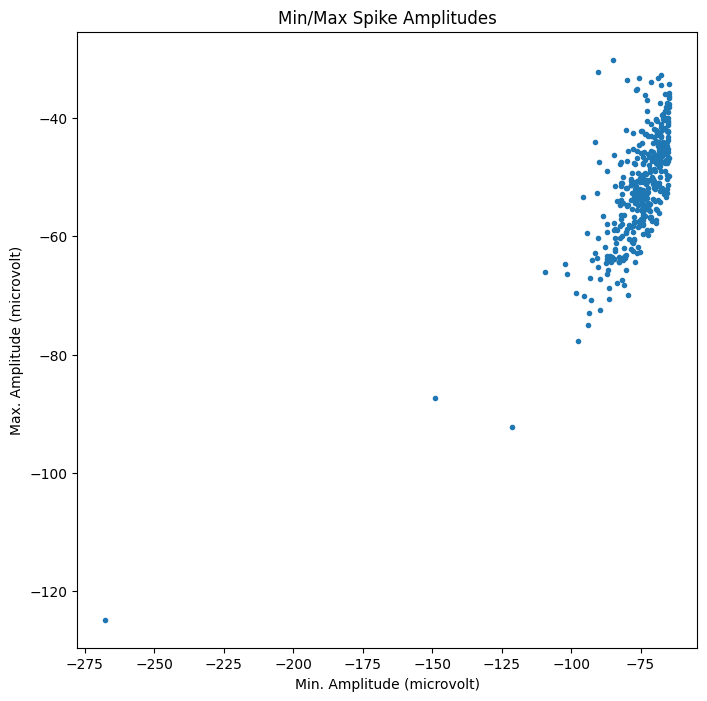

In [288]:
min_amplitude = np.amin(cutouts, axis=1)
max_amplitude = np.amax(cutouts, axis=1)

_ = plt.figure(figsize=(8,8))
_ = plt.plot(min_amplitude*1e6, max_amplitude*1e6,'.')
_ = plt.xlabel('Min. Amplitude (%s)' % ureg.uV)
_ = plt.ylabel('Max. Amplitude (%s)' % ureg.uV)
_ = plt.title('Min/Max Spike Amplitudes')

plt.show()

In [289]:
scaler = StandardScaler()
scaled_cutouts = scaler.fit_transform(cutouts)

pca = PCA()
pca.fit(scaled_cutouts)
print(pca.explained_variance_ratio_)

,n_components,None
,copy,True
,whiten,False
,svd_solver,'auto'
,tol,0.0
,iterated_power,'auto'
,n_oversamples,10
,power_iteration_normalizer,'auto'
,random_state,None


[7.80241218e-01 1.15935780e-01 2.68107889e-02 1.20602434e-02
 1.03860682e-02 8.42277591e-03 6.59357806e-03 4.75367762e-03
 4.52806073e-03 3.99441638e-03 3.23911471e-03 2.79319557e-03
 2.40950685e-03 2.29032162e-03 1.98160684e-03 1.89002362e-03
 1.66483674e-03 1.32651225e-03 1.23742650e-03 9.99362623e-04
 9.12647283e-04 8.56187079e-04 7.37631107e-04 6.06409956e-04
 5.43962236e-04 4.30936290e-04 3.47386099e-04 3.14336134e-04
 2.73557732e-04 2.36661210e-04 1.71275622e-04 1.62279872e-04
 1.34127195e-04 1.14712881e-04 9.45614374e-05 7.62170584e-05
 6.84011446e-05 5.53886117e-05 5.14047860e-05 4.43360816e-05
 3.22884158e-05 2.51541660e-05 2.36955280e-05 2.03424817e-05
 1.83554288e-05 1.51719013e-05 1.32001704e-05 1.06673212e-05
 9.01094240e-06 7.52790679e-06 6.19460958e-06 5.26087525e-06
 4.56850208e-06 4.18345670e-06 3.34769902e-06 3.07305856e-06
 2.34988327e-06 1.92496698e-06 1.60588651e-06 1.14277086e-06]


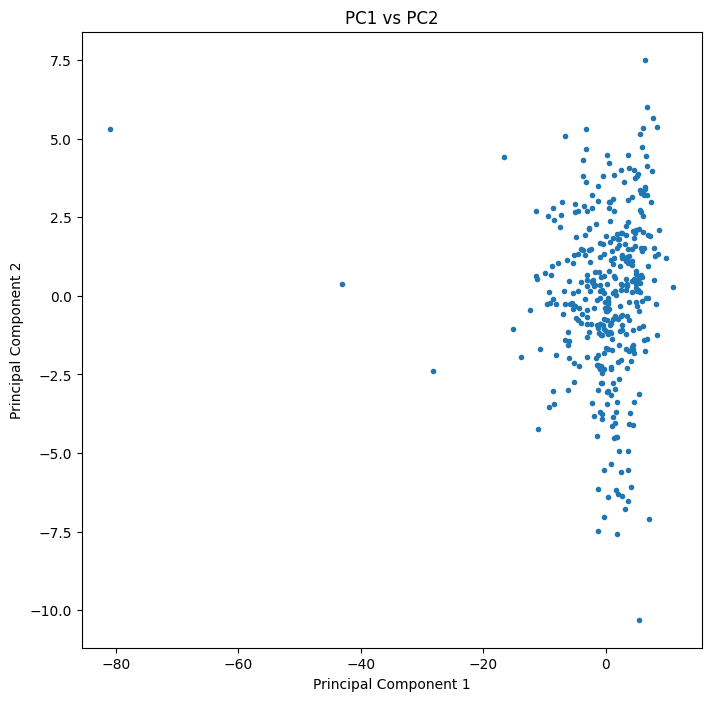

In [290]:

pca.n_components = 2
transformed = pca.fit_transform(scaled_cutouts)

_ = plt.figure(figsize=(8,8))
_ = plt.plot(transformed[:,0], transformed[:,1],'.')
_ = plt.xlabel('Principal Component 1')
_ = plt.ylabel('Principal Component 2')
_ = plt.title('PC1 vs PC2')

plt.show()

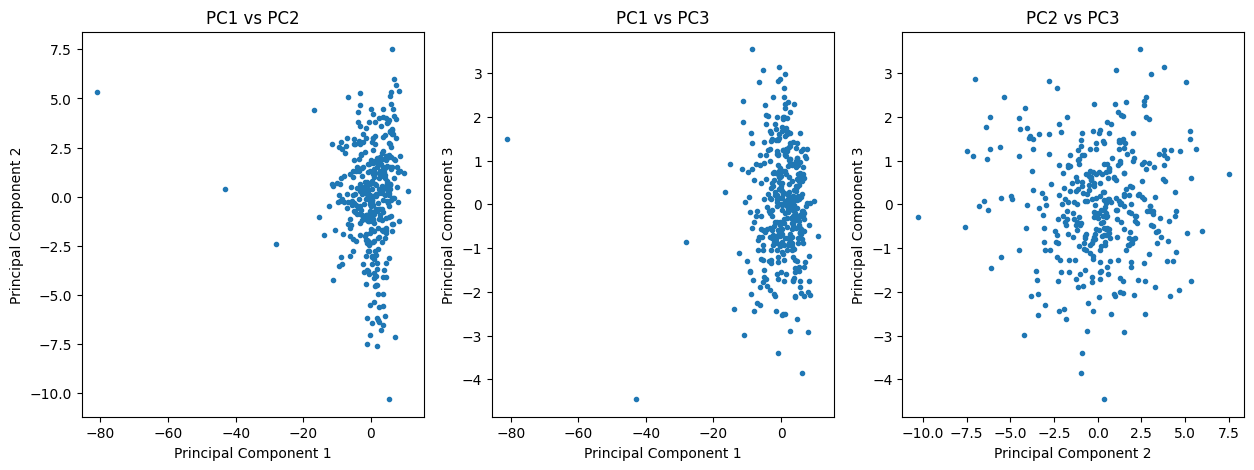

In [291]:
pca.n_components = 3
transformed_3d = pca.fit_transform(scaled_cutouts)

_ = plt.figure(figsize=(15,5))
_ = plt.subplot(1, 3, 1)
_ = plt.plot(transformed_3d[:,0], transformed_3d[:,1],'.')
_ = plt.xlabel('Principal Component 1')
_ = plt.ylabel('Principal Component 2')
_ = plt.title('PC1 vs PC2')
_ = plt.subplot(1, 3, 2)
_ = plt.plot(transformed_3d[:,0], transformed_3d[:,2],'.')
_ = plt.xlabel('Principal Component 1')
_ = plt.ylabel('Principal Component 3')
_ = plt.title('PC1 vs PC3')
_ = plt.subplot(1, 3, 3)
_ = plt.plot(transformed_3d[:,1], transformed_3d[:,2],'.')
_ = plt.xlabel('Principal Component 2')
_ = plt.ylabel('Principal Component 3')
_ = plt.title('PC2 vs PC3')
plt.show()

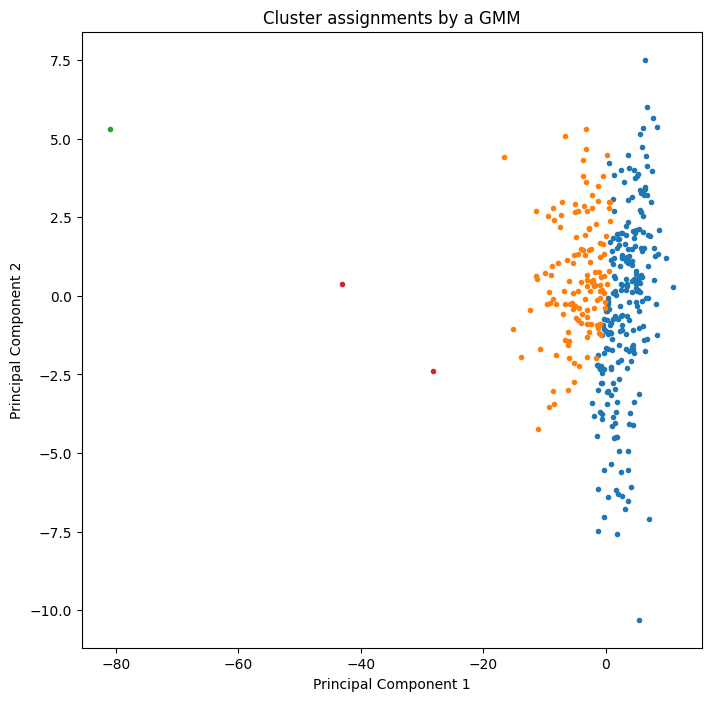

In [292]:
# Clustering
n_components = 4
gmm = GaussianMixture(n_components=n_components, n_init=10)
labels = gmm.fit_predict(transformed)

_ = plt.figure(figsize=(8,8))
for i in range(n_components):
    idx = labels == i
    _ = plt.plot(transformed[idx,0], transformed[idx,1],'.')
    _ = plt.title('Cluster assignments by a GMM')
    _ = plt.xlabel('Principal Component 1')
    _ = plt.ylabel('Principal Component 2')
    _ = plt.axis('tight')
plt.show()

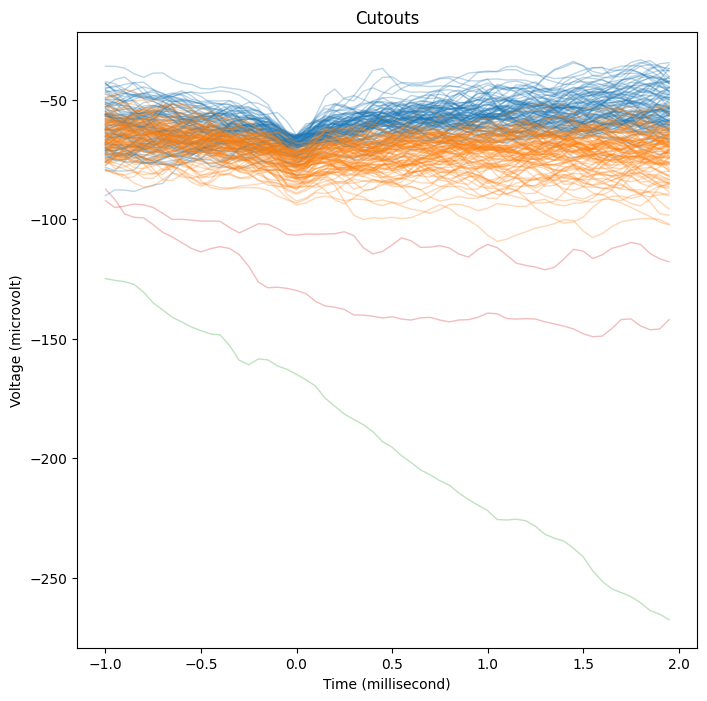

In [296]:

_ = plt.figure(figsize=(8,8))
for i in range(n_components):
    idx = labels == i
    color = plt.rcParams['axes.prop_cycle'].by_key()['color'][i]
    plot_waveforms(cutouts[idx,:], fs, pre, post, n=100, color=color, show=False)
plt.show()